# You'll learn

## ML methods

- Deep NN with BigDL

Course [slides](https://github.com/leggerf/MLCourse-2122/blob/master/Slides/Day4/Big%20data%20science%20-%20Day%204%20-%202122.pdf)

In [1]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1337)  # for reproducibility

from custom_functions import *

In [2]:
num_workers=7 # Do not use more than 7!
spark=%sc_bigDL $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark
#spark._conf.getAll()

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

In [3]:
#init bigDL context

from bigdl.dllib.nncontext import *
sc = init_nncontext()

/opt/conda/lib/python3.9/site-packages/bigdl/dllib/utils/engine.py:45: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark, and pyspark is found in: /home/jovyan/.local/lib/python3.9/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


## Read in input data

In [4]:
# read in input data

#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'    # takes 5-10 minutes
inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet'  # takes about 1 hour to train with 50 epochs

df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

There are 9560096 events


In [5]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

# create input feature vector
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

Events for training 7648952
Events for validation 1911144


In [6]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(train.rdd.getNumPartitions()))
print("Partitioner: {}".format(train.rdd.partitioner))

Number of partitions: 23
Partitioner: None


## Create model

In [7]:
# Create keras-like model: 
# Only need to change package name from tensorflow.keras to bigdl.dllib.keras
# no callbacks in bigDL

from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.utils.common import JTensor

from bigdl.dllib.keras.optimizers import Adam
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.keras.layers.core import Dense, Activation, Dropout

# create the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(28,)))
model.add(Dense(1, activation='sigmoid'))
opt = Adam()

# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


In [8]:
# Set of hyperparameters
numEpochs = 50

# The batch used by BigDL must be a multiple of numExecutors * executorCores because data will be equally distributed inside each executor
workerBatch = 5120
numExecutors = int(sc._conf.get('spark.executor.instances'))
executorCores = int(sc._conf.get('spark.executor.cores'))

BigDLbatch = workerBatch * numExecutors * executorCores

print(str(BigDLbatch))

35840


In [9]:
# Create SparkML compatible estimator for deep learning training
from bigdl.dllib.optim.optimizer import EveryEpoch, Loss, TrainSummary, ValidationSummary
from bigdl.dllib.nnframes import *
from bigdl.dllib.keras.objectives import BinaryCrossEntropy

estimator = NNEstimator(model, BinaryCrossEntropy()) \
        .setOptimMethod(Adam()) \
        .setBatchSize(BigDLbatch) \
        .setMaxEpoch(numEpochs) \
        .setFeaturesCol("features") \
        .setLabelCol("label") \
        .setValidation(trigger=EveryEpoch() , val_df=test, val_method=[Loss(BinaryCrossEntropy())], batch_size=BigDLbatch)

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasBinaryCrossEntropy
creating: createLoss


## Create directory for logs

In [10]:
appName = "Classifier"
logDir = "/home/jovyan/bigDL" 

# Check if there is already an application with the same name and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
estimator.setValidationSummary(valSummary)

Saving logs to /home/jovyan/bigDL/Classifier
creating: createTrainSummary
creating: createValidationSummary


NNEstimator_279805d595e9

## Train model

In [11]:
#keep spark UI close!!! 
%time trained_model = estimator.fit(train)

creating: createToTuple
creating: createChainedPreprocessing
CPU times: user 1min 34s, sys: 26.4 s, total: 2min 1s
Wall time: 58min 48s


In [12]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(test)
#predDF.printSchema()

y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(test.select('label').collect())

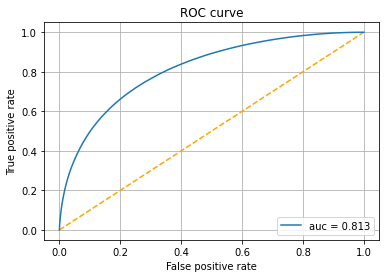

In [13]:
drawROC2(y_true[:,0], y_pred[:,0])

In [14]:
#create dataframe in same format as MLlib
from pyspark.sql import functions as f

#rename prediction to probability (predictions are binary, 0-1)
newDF = predDF.withColumn("probability", f.col("prediction"))
#overwrite prediction with binary values
result = newDF.withColumn('prediction', f.when(f.col("probability")[0]>0.5, 1.).otherwise(0.))
#result.select(["probability", "prediction", "label"]).show()

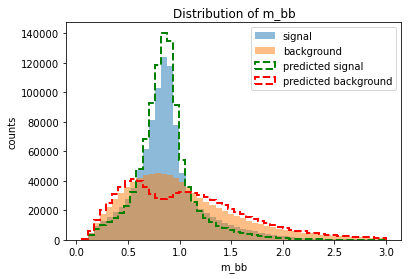

In [15]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result,  'm_bb')

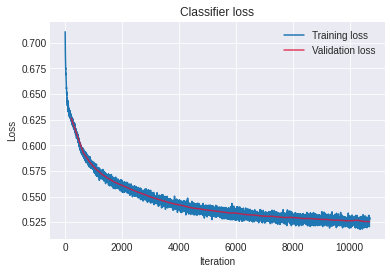

In [16]:
# Plot loss
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("Classifier loss")
plt.show()

In [17]:
#Once done, stop spark
spark.stop()

# Exercise

- play with the batch size, how does it affect performances/training time?
- play with the model parameters and see if you can improve the performances (try to add dropout layers in case of overfitting).
- how is training time affected by the number of parameters?
- try to make scaling tests, i.e. training time vs number of workers (do not go above 25!)
- compare the performances to the models from the previous days